# Stock Price Analysis ML Pipeline

Analyzing stock prices can help with making informed investment decisions - by predicting the future price of a stock we can decide whether we should buy, hold, or sell shares.  Analyzing historic stock prices allows investors to identify trends and patterns in the market which can then be used to make more accurate predictions in the future.

LSTM models are useful for time series data - these models are a type of RNN that were designed to handle the vanishing gradient problem present in traditional RNNs.  LSTM units are composed of cells, an input gate, an output gate, and a forget gate.  The cell unit remembers values over time intervals and the other gates will regulate the flow of information that come into and out of the cell.  The forget gate decides what information should be discarded from a previous state, the input gate decides what new information should be kept, and the output gate decides which piece of information in the current state should be output.  

In this notebook we will be analyzing historic time series data of stock prices with a LSTM model with the goal of predicting the closing price of a stock based on the date and the opening price of the stock.  This information would be useful to day traders who buy and sell stocks within the same trading day. 

To perform this analysis we will be building a ML pipeline using PySpark.  PySpark is a python API for Apache Spark which is an open source big data processing framework.  We will make API calls to obtain stock data and will then use PySpark to put this data into a database table that we create in MySQL.  The below url is a useful guide to using PySpark with MySQL:

https://sparkbyexamples.com/pyspark/pyspark-read-and-write-mysql-database-table/

The flow of the ML pipeline is as follows:

1) Use Polygon.IO API and YFinance API to obtain stock data - we will make API calls to these with Python
2) Transform the results of the API calls with Python before uploading them into a MySQL table
3) Use PySpark to upload the transformed data into a table that we have created in MySQL
4) Use PySpark to load the transformed data so that our LSTM model can be used to analyze it and make predictions
5) Use PyTorch for implementing our LSTM model


## Import Libraries

Requests will be used for the API call, datetime/dateutil will be used for our ETL process, pandas will be used for housing our data, and pyspark.sql will be used for creating our Spark session along with loading data into a table.  We will need the yfinance library so that we can get current day stock data since Polygon.IO will not allow us to get same day stock data with their free version.

In [2]:
# Import necessary libraries
import requests
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import pandas as pd
from pyspark.sql import SparkSession

In [3]:
# Polygon.IO API does not return current day stock data - 
# for current day stock data we will use yfinance - 
# yfinance allows us to download market data from Yahoo! Finance's API 
import yfinance as yf

## Variable Declarations

We need to create some variable that we will later pass to a url for our API call.  We are also going to create a pandas dataframe where we'll create data for our closing price prediction.

In [4]:
# Create a variable to hold the ticker for the stock that we are interested in
# note that in the below we use F for Ford Motor Company
ticker = "F"

# Create two variables to store dates that will be passed
# as parameters to the API calls url string
current_date = str(date.today())
start_date = str((datetime.now() - relativedelta(years=2)).strftime('%Y-%m-%d'))

# Create a list that will hold the current date - note that we have this because
# it can be modified if we want to look further into the future with multiple days
future_dates = []
for i in range(1):
    future_dates.append(str((datetime.now() + relativedelta(days=i)).strftime('%Y-%m-%d')))

# Before our API calls, we are going to create a pandas dataframe for the above date(s)
# We use "date(s)" since the above statement can be modified to allow more than one date
fdf = pd.DataFrame(future_dates)

# Rename column to date instead of 0
fdf = fdf.rename(columns={0:"date"})

# Create a column to store a numeric version of the date
fdf["date_numeric"] = pd.to_datetime(fdf["date"]).dt.strftime("%Y%m%d").astype(int)

# Create a prediction column for the stock price and set it to null
fdf["prediction"] = "NULL"

# Add a column for the stock ticker
fdf["ticker"] = ticker

## API call to Polygon.IO

We'll pass the variables that we defined above to the url string for our API call.  Once the data is extracted, we'll do some transformations and store the data in a pandas dataframe.

In [8]:
# --------------------------
# API call to get stock data
# --------------------------

# Note in the URL we pass the ticker parameter/variable as well as the dates we are interested in
# !!! Also note the API key has been obfuscated
response = requests.get("https://api.polygon.io/v2/aggs/ticker/"+ticker+"/range/1/day/"+start_date+"/"+current_date+"?adjusted=true&sort=asc&&apiKey=##########")

# Set response equal to JSON values
response = response.json()

# Create a dictionary for the data obtained in the JSON
data = {}

# Iterate through the JSON obtained from the API call and
# add the data into our data dictionary
for val in response["results"]:
    # Convert the unix numeric timestamp to a date - the date is our key and the other
    # attributes are the values for our dictionary
    data[datetime.utcfromtimestamp(val['t'] / 1000.0).strftime('%Y-%m-%d')] = val['o'], val['h'], val['l'], \
                                                                              val['c'], val['n'], val['v'], val['t']

# Convert the dictionary into a pandas dataframe                                                                             
df = pd.DataFrame.from_dict(data, orient = 'index')

# Give the columns in the dataframe names
df = df.rename(columns={0:"open", 1:"high", 2:"low", 3:"close", \
                        4:"num_of_trans", 5:"trading_volume", 6:"unix_timestamp"})

# Add a column for the stock ticker 
df["ticker"] = ticker

# Our index is currently the date, we are going to reset this.
df = df.reset_index()

# Rename the reset column as date since it now houses the date
df = df.rename(columns={"index":"date"})

# Create a numeric version of the date
df["date_numeric"] = pd.to_datetime(df["date"]).dt.strftime("%Y%m%d").astype(int)

# Since we have a numeric version of the date, we're going to drop the date column
df = df.drop(["date"], axis=1)


'\n# Note in the URL we pass the ticker parameter/variable as well as the dates we are interested in\n# !!! Also note the API key has been obfuscated\nresponse = requests.get("https://api.polygon.io/v2/aggs/ticker/"+ticker+"/range/1/day/"+start_date+"/"+current_date+"?adjusted=true&sort=asc&&apiKey=##########")\n\n# Set response equal to JSON values\nresponse = response.json()\n\n# Create a dictionary for the data obtained in the JSON\ndata = {}\n\n# Iterate through the JSON obtained from the API call and\n# add the data into our data dictionary\nfor val in response["results"]:\n    # Convert the unix numeric timestamp to a date - the date is our key and the other\n    # attributes are the values for our dictionary\n    data[datetime.utcfromtimestamp(val[\'t\'] / 1000.0).strftime(\'%Y-%m-%d\')] = val[\'o\'], val[\'h\'], val[\'l\'],                                                                               val[\'c\'], val[\'n\'], val[\'v\'], val[\'t\']\n\n# Convert the dictionary int

## API call to YFinance

We'll extract and transform the stock data for today's date with YFinance

In [7]:
# We need to add todays stock data to our df

# The below steps use yfinance to get todays stock data, we then clean the
# results so that they line up more with our historical data that we
# obtained with our API call
curr = yf.Ticker(ticker)
curr = curr.history(period="1day")
curr = curr.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1)
curr = curr.reset_index()
curr["num_of_trans"] = 0
curr["trading_volume"] = 0
curr["unix_timestamp"] = 0
curr = curr.rename(columns={"Open":"open", "High":"high", "Low":"low", "Close":"close", "Date":"date"})
curr["ticker"] = ticker
curr["date_numeric"] = pd.to_datetime(curr["date"]).dt.strftime("%Y%m%d").astype(int)
curr = curr.drop(["date"], axis=1)

# Now we need to add the current days stock data to our historical data
df = df.append(curr, ignore_index=True)

/var/folders/l5/z6z0097s7ks_1l5d1cyzggqw0000gn/T/ipykernel_928/2333265388.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(curr, ignore_index=True)


## PySpark 

Now that we have the data from the API calls input into pandas dataframe we'll use PySpark so that we can insert the information into tables that we have created in MySQL.  Note that the information has been obfuscated.

In [ ]:
# Create a Spark Session using SparkSession.builder - config set to current jar version
spark = SparkSession.builder \
    .master("local[1]") \
    .config("spark.jars", "mysql-connector-j-8.1.0.jar") \
    .appName("STOCKETL") \
    .getOrCreate() 
    
# Create a spark dataframe from our pandas dataframe

# We will do this for both the historical data and our prediction data
sparkDF = spark.createDataFrame(df)
sparkFDF = spark.createDataFrame(fdf)

# Write the data into our historical_data and prediction_data tables in MySQL

# We use overwrite in case there is anything currently in the table

# HISTORICAL DATA WRITE
# ---------------------
sparkDF.write \
  .format("jdbc") \
  .mode("overwrite") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:####/STOCKPRD") \
  .option("dbtable", "HISTORICAL_DATA") \
  .option("user", "##########") \
  .option("password", "##########") \
  .save()
  
# PREDICTED DATA WRITE
# --------------------
sparkFDF.write \
  .format("jdbc") \
  .mode("overwrite") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:####/STOCKPRD") \
  .option("dbtable", "PREDICTION_DATA") \
  .option("user", "##########") \
  .option("password", "##########") \
  .save()

## Architecture for LSTM model 

With our ETL process being complete, we'll start with constructing the LSTM model that we'll use for analyzing the stock data.  

In [10]:
"""
Architecture for the LSTM model ---
"""
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=16, num_layers=1)
        self.linear = nn.Linear(16,1)
      
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

## Import libraries for LSTM model

For this project we're going to use PyTorch for our LSTM model and will also use some data cleaning/processing methods from sklearn.

In [11]:
# Import necessary libraries
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from LSTM_ARCH import LSTM
from sklearn.model_selection import train_test_split

## Standardization and Normalization

In the below we define some functions that we'll use later to standardize/normalize the data.  We have also created a function so that we can "de-normalize" the data for our stock prices.

In [12]:
def ss(X):
    """
    Standardize the data by using the following formula:
        
        z = x - u / o
        
    where x is the scalar value of the data being standardized,
    u is the mean, and o is the standard deviation
    """
    X = X.values # get all values as a matrix
    sc = StandardScaler() # Standard Scaler object
    xsc = sc.fit_transform(X) # Standardize the data
    return xsc

In [13]:
def mm(X):
    """
    Normalize the data using min max normalization
    
    x = x - min(x) / max(x) - min(x)
    """
    X = X.values # get all values as a matrix
    mm = MinMaxScaler() # MinMax Scaler object
    xmm = mm.fit_transform(X.reshape(-1,1)) # Normalize the data
    return xmm

In [14]:
def umm(X, minn, maxx):
    """
    Un-Normalize the data using the below formula
    
    x = x - min(x) / max(x) - min(x)
    
    x = (x * (max(x) - min(x))) + min(x)
    """
    X = (X * (maxx - minn)) + minn
    return X

## Implement the LSTM model with PyTorch

We use ADAM for our optimizer, and also use the weight decay method that PyTorch provides in an attempt to prevent overfitting.  We use MSE for our loss - once this is computed we back propagate the error throughout the network so that the weights can be updated as needed.

In [16]:
def lstm_model(X_train, y_train, X_test, y_test, epochs):
    """
    Use the LSTM model defined above.
    """
    # Initialize the model
    model = LSTM()
    # Use Adaptive Moment Estimation (ADAM) as the optimizer, use weight decay
    # to prevent overfitting
    optimizer = optim.Adam(model.parameters(), weight_decay=.00001)
    # Use MSE as our loss
    loss_fn = nn.MSELoss()
    # Load our data 
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False)
    # Train and test the model
    n_epochs = epochs
    for epoch in range(n_epochs):
        # Train the model
        model.train()
        for X_batch, y_batch in loader:
            # Compute model prediction
            y_pred = model(X_batch)
            # Compute the loss using MSE
            loss = loss_fn(y_pred, y_batch)
            # Call the ADAM optimizer
            optimizer.zero_grad()
            # Back propagate the error
            loss.backward()
            # Update weights
            optimizer.step()
        # Test the model
        model.eval()
        with torch.no_grad():
            # Compute model prediction
            y_pred = model(X_train)
            # Compute the MSE for training data
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            # Compute model prediction
            y_pred = model(X_test)
            # Compute the MSE for the test data
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

    return y_test, y_pred, model.eval()

## Main Function 

Now we use PySpark to extract the stock data obtained from the API calls, once this is done we can partition the data into training and testing sets for the LSTM model.  We'll then use the model's learned weights to predict the future close price of the stock based on the historical data.  As seen in the above we provide further comments throughout in the below.  Note again that some of the information has been obfuscated.

In [ ]:
def main():

    # Create a Spark Session using SparkSession.builder - config set to current jar version
    spark = SparkSession.builder \
        .master("local[1]") \
        .config("spark.jars", "mysql-connector-j-8.1.0.jar") \
        .appName("TEST") \
        .getOrCreate() 
    
    # Read from MySQL Table - 
    # This table holds the historical stock data that we obtained from
    # the API call 
    pysparkDFH = spark.read \
        .format("jdbc") \
        .option("driver","com.mysql.cj.jdbc.Driver") \
        .option("url", "jdbc:mysql://localhost:##########/STOCKPRD") \
        .option("dbtable", "HISTORICAL_DATA") \
        .option("user", "##########") \
        .option("password", "##########") \
        .load()
        
    # Read from MySQL Table -
    # This table is for our prediction data
    pysparkDFP = spark.read \
        .format("jdbc") \
        .option("driver","com.mysql.cj.jdbc.Driver") \
        .option("url", "jdbc:mysql://localhost:##########/STOCKPRD") \
        .option("dbtable", "PREDICTION_DATA") \
        .option("user", "##########") \
        .option("password", "##########") \
        .load()
        
    # Create a pandas dataframe from the pyspark dataframe  
    # One for our historical data and one for our prediction
    pandasDFH = pysparkDFH.toPandas()
    pandasDFP = pysparkDFP.toPandas()
    
    # Our LSTM model will only use the date (numeric) and the open 
    # price of the stock as input
    X = pandasDFH[['date_numeric', 'open']]
    # Set y to our target value (the closing price of the stock)
    y = pandasDFH['close']
    
    # Use scikit learn to split the data - note that we want shuffle to be false
    # since we are dealing with time series data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)
    
    # Get the min and max values of our test set y variables (closing price of stock)
    # We will need these values to "de-normalize" our data
    minn = min(y_test)
    maxx = max(y_test)
    
    # Standardize X, Normalize y
    X_train = ss(X_train)
    X_test = ss(X_test)
    y_train = mm(y_train)
    y_test = mm(y_test)
    
    # Print data shape (for testing/checks)
    print("Training Shape:", X_train.shape, y_train.shape)
    print("Testing Shape:", X_test.shape, y_test.shape) 
    
    # Convert data to pytorch tensors
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))
    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))
    
    # Create and call lstm model
    # We'll train the model for 100 epochs
    epochs = 100
    yt, yp, m = lstm_model(X_train_tensors, y_train_tensors, X_test_tensors, y_test_tensors, epochs)
    
    # Convert pytorch tensors to numpy arrays for de-normalization
    yp = yp.detach().cpu().numpy()
    yt = yt.detach().cpu().numpy()
    
    # De-normalize the data
    ypmod = umm(yp, minn, maxx)
    ytmod = umm(yt, minn, maxx)
    
    # Plot our model's prediction vs the true results
    plt.plot(ytmod, label = "True Values")
    plt.plot(ypmod, label = "Predicted Values")
    plt.title("Stock Analysis")
    plt.legend()
    plt.show()
    
    # For predicting todays closing price we need
    # to store the opening price of the stock in
    # a variable
    current_day_data = pandasDFH.tail(1)
    
    # Reset/drop index
    current_day_data = current_day_data.reset_index(drop = True)
    
    # Join the current days stock data with the data we have
    # in our prediction_data table
    # Note that we only want the 'open' price added in
    data = pandasDFP.join(current_day_data[['open']])
    data = data[['date_numeric', 'open']]
    
    # Standardize the data for the LSTM model
    data = ss(data)
    
    # Convert to torch tensor
    data = Variable(torch.Tensor(data))
    
    # Pass todays date with the stock open price
    # to our model to try and predict what the closing
    # price of the stock will be 
    m.eval()
    with torch.no_grad():
        # Compute model prediction
        y_pred = m(data)
        # De-normalize the data
        ypmod = umm(y_pred, minn, maxx)
    
    # Add our prediction to our dataframe
    pandasDFP["prediction"] = ypmod
    
    # Convert the pandas df to a spark df so that we can input
    # the results into our prediction_data table in MySQL
    sparkFDF = spark.createDataFrame(pandasDFP)
    
    # PREDICTED DATA WRITE
    # --------------------
    sparkFDF.write \
      .format("jdbc") \
      .mode("overwrite") \
      .option("driver","com.mysql.cj.jdbc.Driver") \
      .option("url", "jdbc:mysql://localhost:##########/STOCKPRD") \
      .option("dbtable", "PREDICTION_DATA") \
      .option("user", "##########") \
      .option("password", "##########") \
      .save() 
      
    # Print prediction
    print(pandasDFP)
    
main()

In [ ]:
Training Shape: (351, 2) (351, 1)
Testing Shape: (151, 2) (151, 1)
Epoch 0: train RMSE 0.3449, test RMSE 0.3201
Epoch 1: train RMSE 0.3834, test RMSE 0.2942
Epoch 2: train RMSE 0.3387, test RMSE 0.2392
Epoch 3: train RMSE 0.3137, test RMSE 0.2196
Epoch 4: train RMSE 0.3131, test RMSE 0.2200
Epoch 5: train RMSE 0.3099, test RMSE 0.2178
Epoch 6: train RMSE 0.3065, test RMSE 0.2148
Epoch 7: train RMSE 0.3027, test RMSE 0.2113
Epoch 8: train RMSE 0.2993, test RMSE 0.2079
Epoch 9: train RMSE 0.2965, test RMSE 0.2047
Epoch 10: train RMSE 0.2944, test RMSE 0.2022
Epoch 11: train RMSE 0.2931, test RMSE 0.2003
Epoch 12: train RMSE 0.2924, test RMSE 0.1990
Epoch 13: train RMSE 0.2921, test RMSE 0.1981
Epoch 14: train RMSE 0.2920, test RMSE 0.1974
Epoch 15: train RMSE 0.2918, test RMSE 0.1968
Epoch 16: train RMSE 0.2915, test RMSE 0.1962
Epoch 17: train RMSE 0.2911, test RMSE 0.1955
Epoch 18: train RMSE 0.2905, test RMSE 0.1948
Epoch 19: train RMSE 0.2898, test RMSE 0.1940
Epoch 20: train RMSE 0.2890, test RMSE 0.1933
Epoch 21: train RMSE 0.2883, test RMSE 0.1925
Epoch 22: train RMSE 0.2875, test RMSE 0.1917
Epoch 23: train RMSE 0.2867, test RMSE 0.1910
Epoch 24: train RMSE 0.2859, test RMSE 0.1903
Epoch 25: train RMSE 0.2851, test RMSE 0.1896
Epoch 26: train RMSE 0.2843, test RMSE 0.1889
Epoch 27: train RMSE 0.2836, test RMSE 0.1882
Epoch 28: train RMSE 0.2828, test RMSE 0.1875
Epoch 29: train RMSE 0.2820, test RMSE 0.1869
Epoch 30: train RMSE 0.2813, test RMSE 0.1862
Epoch 31: train RMSE 0.2805, test RMSE 0.1856
Epoch 32: train RMSE 0.2798, test RMSE 0.1849
Epoch 33: train RMSE 0.2791, test RMSE 0.1843
Epoch 34: train RMSE 0.2784, test RMSE 0.1837
Epoch 35: train RMSE 0.2773, test RMSE 0.1827
Epoch 36: train RMSE 0.2769, test RMSE 0.1824
Epoch 37: train RMSE 0.2762, test RMSE 0.1818
Epoch 38: train RMSE 0.2757, test RMSE 0.1813
Epoch 39: train RMSE 0.2744, test RMSE 0.1802
Epoch 40: train RMSE 0.2742, test RMSE 0.1801
Epoch 41: train RMSE 0.2734, test RMSE 0.1794
Epoch 42: train RMSE 0.2729, test RMSE 0.1789
Epoch 43: train RMSE 0.2722, test RMSE 0.1784
Epoch 44: train RMSE 0.2716, test RMSE 0.1778
Epoch 45: train RMSE 0.2708, test RMSE 0.1772
Epoch 46: train RMSE 0.2702, test RMSE 0.1766
Epoch 47: train RMSE 0.2695, test RMSE 0.1761
Epoch 48: train RMSE 0.2689, test RMSE 0.1756
Epoch 49: train RMSE 0.2683, test RMSE 0.1751
Epoch 50: train RMSE 0.2677, test RMSE 0.1746
Epoch 51: train RMSE 0.2670, test RMSE 0.1740
Epoch 52: train RMSE 0.2664, test RMSE 0.1735
Epoch 53: train RMSE 0.2658, test RMSE 0.1730
Epoch 54: train RMSE 0.2652, test RMSE 0.1725
Epoch 55: train RMSE 0.2646, test RMSE 0.1720
Epoch 56: train RMSE 0.2640, test RMSE 0.1716
Epoch 57: train RMSE 0.2634, test RMSE 0.1711
Epoch 58: train RMSE 0.2628, test RMSE 0.1706
Epoch 59: train RMSE 0.2623, test RMSE 0.1701
Epoch 60: train RMSE 0.2617, test RMSE 0.1697
Epoch 61: train RMSE 0.2612, test RMSE 0.1692
Epoch 62: train RMSE 0.2606, test RMSE 0.1688
Epoch 63: train RMSE 0.2601, test RMSE 0.1684
Epoch 64: train RMSE 0.2595, test RMSE 0.1679
Epoch 65: train RMSE 0.2590, test RMSE 0.1675
Epoch 66: train RMSE 0.2585, test RMSE 0.1671
Epoch 67: train RMSE 0.2580, test RMSE 0.1667
Epoch 68: train RMSE 0.2575, test RMSE 0.1663
Epoch 69: train RMSE 0.2570, test RMSE 0.1659
Epoch 70: train RMSE 0.2566, test RMSE 0.1656
Epoch 71: train RMSE 0.2562, test RMSE 0.1652
Epoch 72: train RMSE 0.2557, test RMSE 0.1649
Epoch 73: train RMSE 0.2553, test RMSE 0.1646
Epoch 74: train RMSE 0.2550, test RMSE 0.1642
Epoch 75: train RMSE 0.2546, test RMSE 0.1639
Epoch 76: train RMSE 0.2542, test RMSE 0.1636
Epoch 77: train RMSE 0.2538, test RMSE 0.1633
Epoch 78: train RMSE 0.2534, test RMSE 0.1630
Epoch 79: train RMSE 0.2530, test RMSE 0.1626
Epoch 80: train RMSE 0.2526, test RMSE 0.1623
Epoch 81: train RMSE 0.2522, test RMSE 0.1619
Epoch 82: train RMSE 0.2518, test RMSE 0.1615
Epoch 83: train RMSE 0.2514, test RMSE 0.1612
Epoch 84: train RMSE 0.2511, test RMSE 0.1609
Epoch 85: train RMSE 0.2507, test RMSE 0.1605
Epoch 86: train RMSE 0.2503, test RMSE 0.1602
Epoch 87: train RMSE 0.2499, test RMSE 0.1599
Epoch 88: train RMSE 0.2493, test RMSE 0.1593
Epoch 89: train RMSE 0.2489, test RMSE 0.1589
Epoch 90: train RMSE 0.2484, test RMSE 0.1585
Epoch 91: train RMSE 0.2481, test RMSE 0.1582
Epoch 92: train RMSE 0.2476, test RMSE 0.1577
Epoch 93: train RMSE 0.2472, test RMSE 0.1573
Epoch 94: train RMSE 0.2467, test RMSE 0.1568
Epoch 95: train RMSE 0.2459, test RMSE 0.1561
Epoch 96: train RMSE 0.2458, test RMSE 0.1561
Epoch 97: train RMSE 0.2455, test RMSE 0.1557
Epoch 98: train RMSE 0.2451, test RMSE 0.1554
Epoch 99: train RMSE 0.2447, test RMSE 0.1550

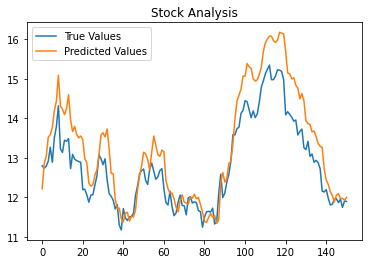

Our model predicts the below for the closing price of the stock:

In [ ]:
         date  date_numeric  prediction ticker
0  2023-08-28      20230828   12.408943      F